# Pendahuluan


Dataset ini merupakan hasil pengumpulan data dari aktivitas A/B testing yang dilakukan untuk mengevaluasi efektivitas dua versi berbeda dari suatu platform atau website (Version A dan Version B). A/B testing adalah metode eksperimen yang membandingkan dua varian untuk menentukan mana yang memiliki performa lebih baik berdasarkan metrik tertentu, dalam hal ini conversion rate.

---
Struktur Dataset:

Dataset ab_testing.csv terdiri dari 5000 baris data dengan 7 kolom yang menyediakan informasi berikut:
1. User ID : Identifier unik untuk setiap pengguna dalam eksperimen.
2. Group: Menunjukkan kelompok eksperimen tempat pengguna ditempatkan (A atau B).
3. Page Views: Jumlah halaman yang dilihat oleh pengguna selama sesi mereka.
4. Time Spent: Waktu (dalam satuan detik) yang dihabiskan pengguna pada platform.
5. Conversion: Indikator apakah pengguna melakukan konversi (misalnya pembelian, pendaftaran, dll).
6. Device: Jenis perangkat yang digunakan pengguna (misalnya desktop, mobile, tablet).
7. Location: Lokasi negara pengguna berasal.



Jadi, dalam skenario ini, warna Putih diasosiasikan dengan Grup A yang merupakan pengaturan latar belakang default pada situs web, yang berperan sebagai kelompok kontrol. Sementara itu, warna Hitam diasosiasikan dengan Grup B, yaitu pengaturan baru yang akan diuji. Tujuan utamanya adalah untuk memahami apakah terdapat peningkatan signifikan dalam jumlah tampilan situs web jika pengaturan baru tersebut diterapkan. Hal ini dapat dijawab melalui penggunaan metode A/B Testing

# Import Library & Load Dataset

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency,shapiro, levene, mannwhitneyu
df = pd.read_csv('https://raw.githubusercontent.com/JaysyuMuhammad/Analisis-A-B-Testing-terhadap-Performa-Website-Berdasarkan-Konversi-dan-Perilaku-Pelanggan/b68344d3be0be6bf2724728aad83d0ab11a2f661/ab_testing.csv')
df

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland
...,...,...,...,...,...,...,...
4995,16360,B,12,313,No,Mobile,Wales
4996,18084,B,10,313,No,Desktop,Northern Ireland
4997,12063,A,11,156,No,Desktop,England
4998,18647,B,13,346,No,Desktop,Wales


# Preprocessing

In [8]:
df.isnull().sum()

,0
User ID,0
Group,0
Page Views,0
Time Spent,0
Conversion,0
Device,0
Location,0


In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df['conversion_binary'] = df['Conversion'].map({'Yes': 1, 'No': 0})

# EDA

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   User ID            5000 non-null   int64 
 1   Group              5000 non-null   object
 2   Page Views         5000 non-null   int64 
 3   Time Spent         5000 non-null   int64 
 4   Conversion         5000 non-null   object
 5   Device             5000 non-null   object
 6   Location           5000 non-null   object
 7   conversion_binary  5000 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 312.6+ KB


In [28]:
df.describe()

,User ID,Page Views,Time Spent,conversion_binary
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,14925.159000,7.537600,242.512600,0.097000
std,2869.153773,4.022465,118.254153,0.295987
min,10001.000000,1.000000,40.000000,0.000000
25%,12456.250000,4.000000,137.000000,0.000000
50%,14858.500000,8.000000,243.000000,0.000000
75%,17379.750000,11.000000,346.000000,0.000000
max,19995.000000,14.000000,449.000000,1.000000


In [29]:
df.groupby('Group').agg({'User ID':'nunique', 'Page Views':'mean', 'Time Spent':'mean'})

,User ID,Page Views,Time Spent
Group,,,
A,2519,7.581580,241.733227
B,2481,7.492946,243.303910


In [30]:
df.groupby('Device').agg({'User ID':'nunique', 'Page Views':'mean', 'Time Spent':'mean'})

,User ID,Page Views,Time Spent
Device,,,
Desktop,2538,7.530339,243.185579
Mobile,2462,7.545085,241.818846


In [31]:
df.groupby('Location').agg({'User ID':'nunique', 'Page Views':'mean', 'Time Spent':'mean'})

,User ID,Page Views,Time Spent
Location,,,
England,1246,7.612360,245.896469
Northern Ireland,1242,7.485507,243.160225
Scotland,1281,7.583919,234.281030
Wales,1231,7.466288,247.000000


In [32]:
df.groupby(['Group','Device','Location']).agg({'User ID':'nunique', 'Page Views':'mean', 'Time Spent':'mean'})

User ID  Page Views  Time Spent
Group Device  Location                                         
A     Desktop England               286    7.472028  233.909091
              Northern Ireland      322    7.677019  242.965839
              Scotland              324    7.456790  240.537037
              Wales                 312    7.464744  254.448718
      Mobile  England               320    7.696875  248.687500
              Northern Ireland      292    7.616438  233.914384
              Scotland              346    7.797688  235.566474
              Wales                 317    7.441640  243.160883
B     Desktop England               335    7.782090  243.964179
              Northern Ireland      320    7.403125  249.862500
              Scotland              330    7.469697  231.118182
              Wales                 309    7.498382  248.533981
      Mobile  England               305    7.468852  256.331148
              Northern Ireland      308    7.246753  245.165584
              Scotland              281    7.601423  229.199288
              Wales                 293    7.460751  241.604096

In [33]:
rate_a = df[df['Group'] == 'A']['conversion_binary'].mean()
rate_b = df[df['Group'] == 'B']['conversion_binary'].mean()
print(f'Conversion Rate Grup A: {rate_a}')
print(f'Conversion Rate Grup B: {rate_b}')

Conversion Rate Grup A: 0.05398967844382691
Conversion Rate Grup B: 0.14066908504635228


In [34]:
df.groupby(['Group', 'Device','Location'])['conversion_binary'].mean()

Group  Device   Location        
A      Desktop  England             0.073427
                Northern Ireland    0.055901
                Scotland            0.052469
                Wales               0.054487
       Mobile   England             0.065625
                Northern Ireland    0.044521
                Scotland            0.046243
                Wales               0.041009
B      Desktop  England             0.158209
                Northern Ireland    0.109375
                Scotland            0.136364
                Wales               0.152104
       Mobile   England             0.134426
                Northern Ireland    0.120130
                Scotland            0.167260
                Wales               0.150171
Name: conversion_binary, dtype: float64

# AB Testing

In [35]:
# Pisahkan 2 grup
group_a = df[df['Group'] == 'A']
group_b = df[df['Group'] == 'B']

## Conversion
Hipotesis:
- H₀ : (Conversion_A = Conversion_B) Tidak ada perbedaan tingkat konversi antara Grup A dan Grup B
- H₁ : (Conversion_A ≠ Conversion_B) Ada perbedaan tingkat konversi antara Grup A dan Grup B.

In [36]:
# Data untuk z-test proporsi
successes = [group_a['conversion_binary'].sum(), group_b['conversion_binary'].sum()]
n_obs = [len(group_a), len(group_b)]

# Z-test
z_stat, p_val_z = proportions_ztest(count=successes, nobs=n_obs)

# Buat tabel kontingensi untuk chi-square
contingency = pd.crosstab(df['Group'], df['Conversion'])
chi2, p_val_chi, _, _ = stats.chi2_contingency(contingency)

# Cetak hasil dengan kesimpulan per metrik
print("=== Metrik: Conversion Rate ===")

# Z-Test
print(f"[Z-Test] Z = {z_stat:.4f}, p-value = {p_val_z:.4g}")
if p_val_z < 0.05:
    print("❌ H₀ ditolak: Ada perbedaan signifikan tingkat konversi antara Grup A dan B.")
else:
    print("✅ H₀ diterima: Tidak ada perbedaan signifikan tingkat konversi antara Grup A dan B.")

# Chi-Square
print(f"[Chi-Square] χ² = {chi2:.4f}, p-value = {p_val_chi:.4g}")
if p_val_chi < 0.05:
    print("❌ H₀ ditolak: Ada perbedaan signifikan tingkat konversi antara Grup A dan B.")
else:
    print("✅ H₀ diterima: Tidak ada perbedaan signifikan tingkat konversi antara Grup A dan B.")

=== Metrik: Conversion Rate ===
[Z-Test] Z = -10.3545, p-value = 3.993e-25
❌ H₀ ditolak: Ada perbedaan signifikan tingkat konversi antara Grup A dan B.
[Chi-Square] χ² = 106.2281, p-value = 6.572e-25
❌ H₀ ditolak: Ada perbedaan signifikan tingkat konversi antara Grup A dan B.


## Time Spent
Hipotesis :
- H₀: (μ_A = μ_B) : Rata-rata time spent pengguna Grup A sama dengan Grup B.
- H₁: (μ_A ≠ μ_B) : Rata-rata time spent pengguna Grup A tidak sama dengan Grup B.

In [37]:

# === Uji Normalitas Time Spent ===
stat_norm_a_ts, p_norm_a_ts = shapiro(group_a['Time Spent'])
stat_norm_b_ts, p_norm_b_ts = shapiro(group_b['Time Spent'])

# === Uji Homogenitas Varians Time Spent ===
stat_levene_ts, p_levene_ts = levene(group_a['Time Spent'], group_b['Time Spent'])

print("=== Uji Asumsi Normalitas - Time Spent ===")
print(f"Group A p-value = {p_norm_a_ts:.4g}, Group B p-value = {p_norm_b_ts:.4g}")
print("✅ Normal" if p_norm_a_ts > 0.05 and p_norm_b_ts > 0.05 else "❌ Tidak normal")

print("\n=== Uji Homogenitas Varians - Time Spent ===")
print(f"p-value = {p_levene_ts:.4g}")
print("✅ Varians sama (homogen)" if p_levene_ts > 0.05 else "❌ Varians beda (tidak homogen)")


=== Uji Asumsi Normalitas - Time Spent ===
Group A p-value = 3.083e-27, Group B p-value = 6.18e-28
❌ Tidak normal

=== Uji Homogenitas Varians - Time Spent ===
p-value = 0.1992
✅ Varians sama (homogen)


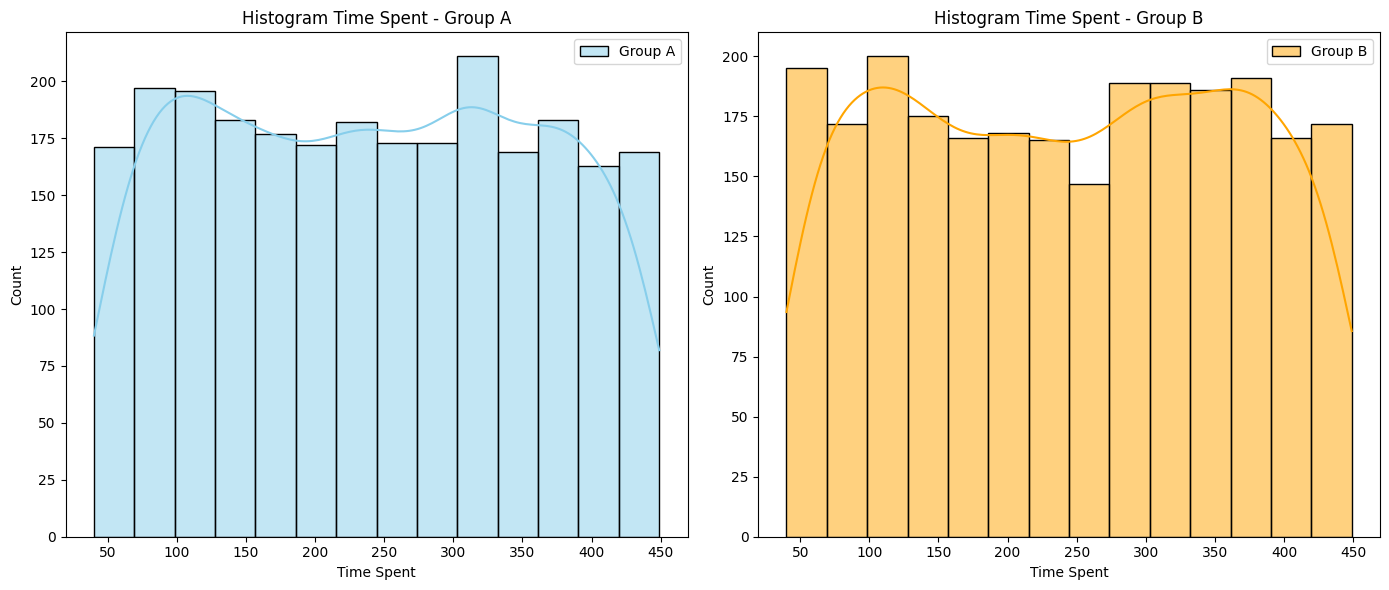

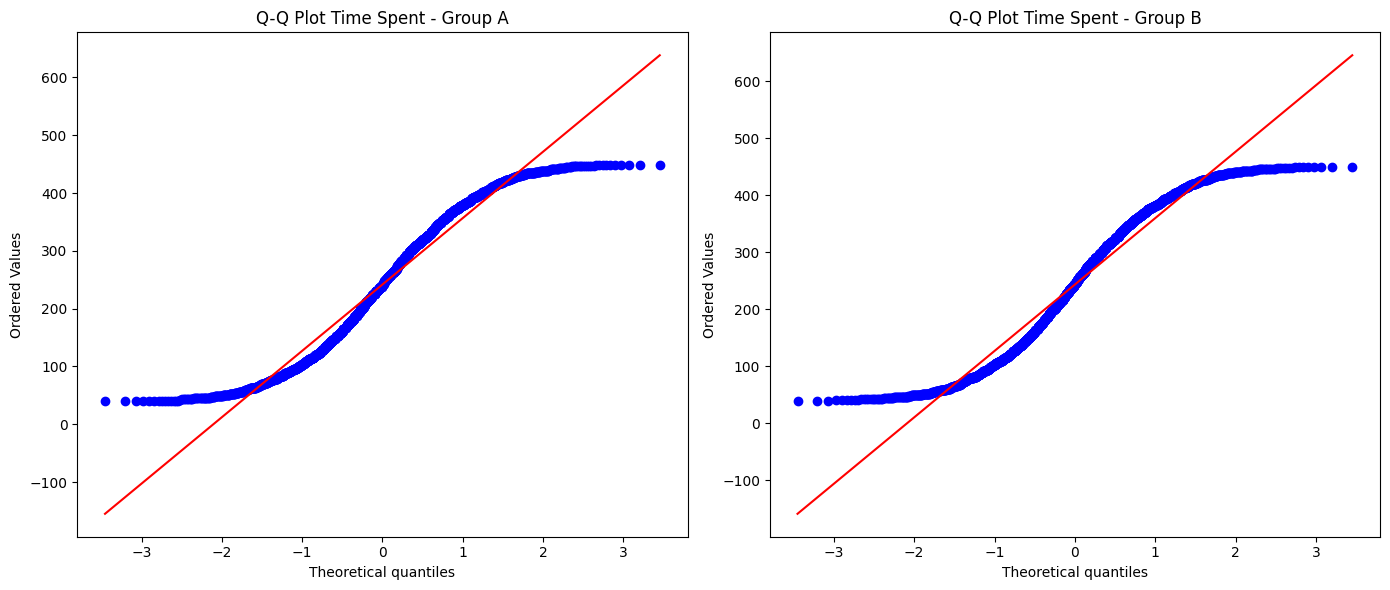

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Histogram Time Spent - Group A
sns.histplot(group_a['Time Spent'], kde=True, color='skyblue', label='Group A', ax=axs[0], stat='count')
axs[0].set_title('Histogram Time Spent - Group A')
axs[0].set_xlabel('Time Spent')
axs[0].legend()

# Histogram Time Spent - Group B
sns.histplot(group_b['Time Spent'], kde=True, color='orange', label='Group B', ax=axs[1], stat='count')
axs[1].set_title('Histogram Time Spent - Group B')
axs[1].set_xlabel('Time Spent')
axs[1].legend()

plt.tight_layout()
plt.show()

# Q-Q Plot Time Spent
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

stats.probplot(group_a['Time Spent'], dist="norm", plot=axs[0])
axs[0].set_title('Q-Q Plot Time Spent - Group A')

stats.probplot(group_b['Time Spent'], dist="norm", plot=axs[1])
axs[1].set_title('Q-Q Plot Time Spent - Group B')

plt.tight_layout()
plt.show()


In [39]:
# Mann-Whitney U Test untuk Time Spent
stat_ts, p_ts = mannwhitneyu(group_a['Time Spent'], group_b['Time Spent'], alternative='two-sided')
print("=== Uji Statistik - Time Spent ===")
print(f"Uji Mann-Whitney U: p-value = {p_ts:.4g}")

if p_ts < 0.05:
    print("❌ H₀ ditolak → Ada perbedaan signifikan dalam rata-rata Time Spent antara Grup A dan B")
else:
    print("✅ H₀ diterima → Tidak ada perbedaan signifikan dalam rata-rata Time Spent antara Grup A dan B")


=== Uji Statistik - Time Spent ===
Uji Mann-Whitney U: p-value = 0.642
✅ H₀ diterima → Tidak ada perbedaan signifikan dalam rata-rata Time Spent antara Grup A dan B


## Page Views
Hipotesis :
- H₀: (μ_PageViews_A = μ_PageViews_B) = Rata-rata page views antara Grup A dan Grup B sama.
- H₁: (μ_PageViews_A ≠ μ_PageViews_B) = Rata-rata page views antara Grup A dan Grup B berbeda.


In [40]:
# === Uji Normalitas Page Views ===
stat_norm_a_pv, p_norm_a_pv = shapiro(group_a['Page Views'])
stat_norm_b_pv, p_norm_b_pv = shapiro(group_b['Page Views'])

# === Uji Homogenitas Varians Page Views ===
stat_levene_pv, p_levene_pv = levene(group_a['Page Views'], group_b['Page Views'])

print("=== Uji Asumsi Normalitas - Page Views ===")
print(f"Group A p-value = {p_norm_a_pv:.4g}, Group B p-value = {p_norm_b_pv:.4g}")
print("✅ Normal" if p_norm_a_pv > 0.05 and p_norm_b_pv > 0.05 else "❌ Tidak normal")

print("\n=== Uji Homogenitas Varians - Page Views ===")
print(f"p-value = {p_levene_pv:.4g}")
print("✅ Varians sama (homogen)" if p_levene_pv > 0.05 else "❌ Varians beda (tidak homogen)")


=== Uji Asumsi Normalitas - Page Views ===
Group A p-value = 2.137e-30, Group B p-value = 9.74e-29
❌ Tidak normal

=== Uji Homogenitas Varians - Page Views ===
p-value = 0.07629
✅ Varians sama (homogen)


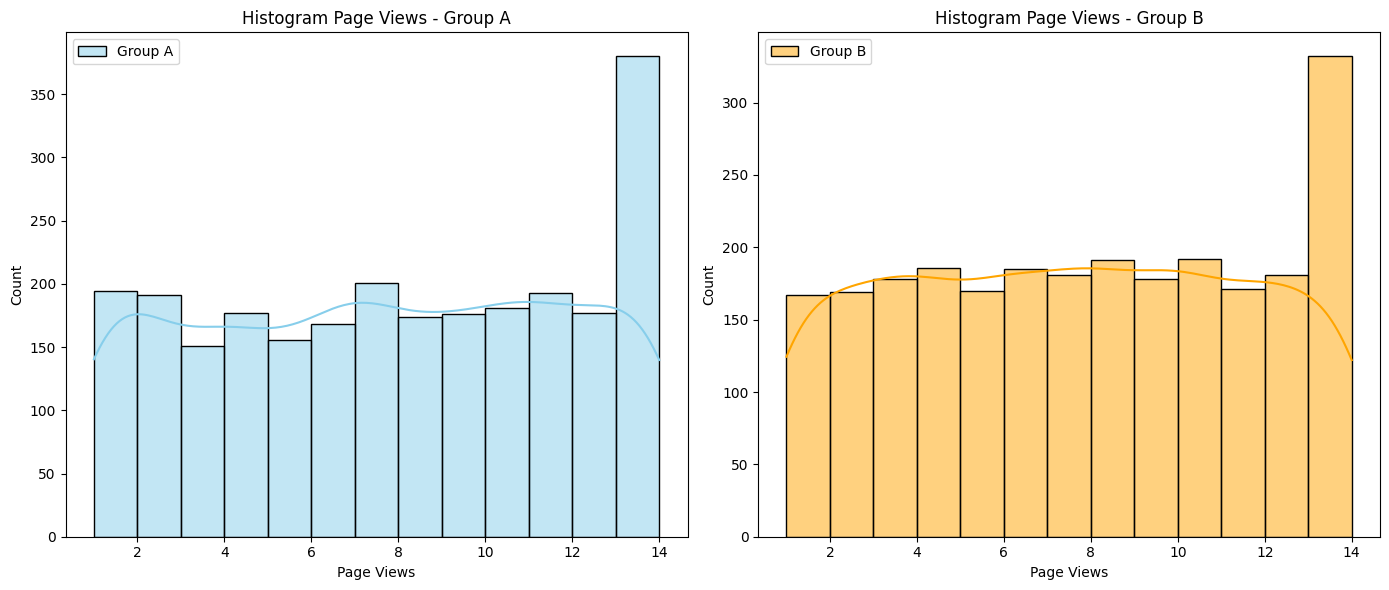

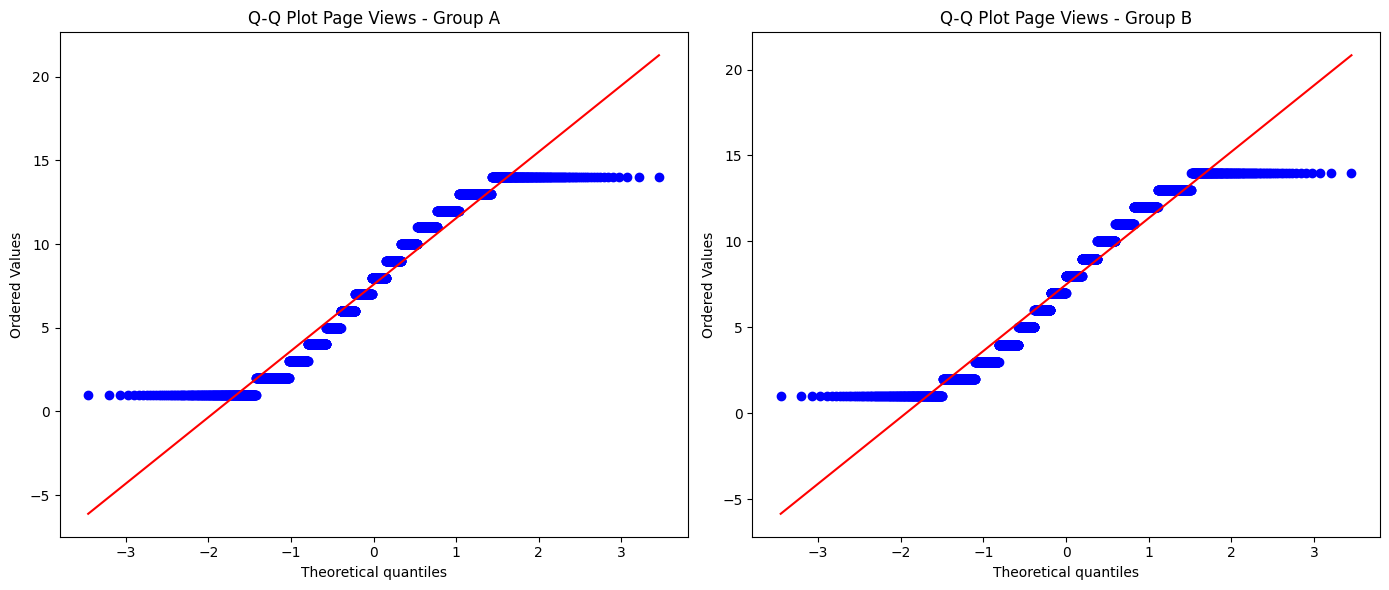

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Histogram Page Views - Group A
sns.histplot(group_a['Page Views'], kde=True, color='skyblue', label='Group A', ax=axs[0], stat='count')
axs[0].set_title('Histogram Page Views - Group A')
axs[0].set_xlabel('Page Views')
axs[0].legend()

# Histogram Page Views - Group B
sns.histplot(group_b['Page Views'], kde=True, color='orange', label='Group B', ax=axs[1], stat='count')
axs[1].set_title('Histogram Page Views - Group B')
axs[1].set_xlabel('Page Views')
axs[1].legend()

plt.tight_layout()
plt.show()

# Q-Q Plot Page Views
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

stats.probplot(group_a['Page Views'], dist="norm", plot=axs[0])
axs[0].set_title('Q-Q Plot Page Views - Group A')

stats.probplot(group_b['Page Views'], dist="norm", plot=axs[1])
axs[1].set_title('Q-Q Plot Page Views - Group B')

plt.tight_layout()
plt.show()


In [42]:
# Mann-Whitney U Test untuk Page Views
stat_pv, p_pv = mannwhitneyu(group_a['Page Views'], group_b['Page Views'], alternative='two-sided')
print("=== Uji Statistik - Page Views ===")
print(f"Uji Mann-Whitney U: p-value = {p_pv:.4g}")
if p_pv < 0.05:
    print("❌ H₀ ditolak → Ada perbedaan signifikan dalam rata-rata Time Spent antara Grup A dan B")
else:
    print("✅ H₀ diterima → Tidak ada perbedaan signifikan dalam rata-rata Time Spent antara Grup A dan B")


=== Uji Statistik - Page Views ===
Uji Mann-Whitney U: p-value = 0.4247
✅ H₀ diterima → Tidak ada perbedaan signifikan dalam rata-rata Time Spent antara Grup A dan B


# Kesimpulan

### **Kesimpulan Analisis A/B Testing pada Website E-Commerce**

Setelah dilakukan eksplorasi data dan uji statistik terhadap 5.000 data pengguna sebuah website e-commerce, yang dibagi menjadi dua kelompok yaitu **Group A** (2.519 pengguna) dan **Group B** (2.481 pengguna), diperoleh beberapa temuan penting sebagai berikut:

---

#### **1. Tingkat Konversi**
- **Group B** (dengan tampilan latar belakang website berwarna hitam) memiliki tingkat konversi lebih tinggi, yaitu sekitar **14%**, dibandingkan **Group A** (latar belakang putih) yang hanya sekitar **5%**.
- Uji statistik menggunakan **Z-Test** dan **Chi-Square Test** menunjukkan bahwa terdapat **perbedaan yang signifikan** dalam tingkat konversi antara kedua grup:
  - **Z-Test** menghasilkan *p-value* sebesar **3.993e-25**
  - **Chi-Square Test** menghasilkan *p-value* sebesar **6.572e-25**
- Kedua *p-value* tersebut jauh di bawah ambang signifikansi **α = 0.05**, sehingga **hipotesis nol (H₀) ditolak**.
- **Kesimpulan**: Perbedaan perlakuan (warna latar belakang) antara Group A dan B **berdampak signifikan terhadap konversi pengguna**.

#### **2. Time Spent (Waktu yang Dihabiskan di Website)**
- Uji asumsi menunjukkan bahwa data **tidak berdistribusi normal**, namun varians antar grup masih **homogen**.
- Karena asumsi normalitas tidak terpenuhi, digunakan **uji non-parametrik Mann-Whitney U Test**.
- Hasil uji menunjukkan *p-value* sebesar **0.642**.
- Karena nilai tersebut > 0.05, maka **hipotesis nol (H₀) diterima**.
- **Kesimpulan**: **Tidak terdapat perbedaan signifikan** dalam rata-rata waktu yang dihabiskan di website antara Group A dan Group B.

#### **3. Page Views (Jumlah Halaman yang Dilihat)**
- Data untuk "Page Views" juga **tidak berdistribusi normal**, namun tetap **homogen**.
- Digunakan uji **Mann-Whitney U Test**, yang menghasilkan *p-value* sebesar **0.4247**.
- Karena nilai tersebut > 0.05, maka **hipotesis nol (H₀) diterima**.
- **Kesimpulan**: **Tidak terdapat perbedaan signifikan** dalam jumlah halaman yang dilihat antara Group A dan Group B.

#### **4. Analisis Tambahan (Lokasi dan Device)**
- **Group B secara konsisten menunjukkan conversion rate yang lebih tinggi** dibandingkan Group A pada semua kombinasi **device** dan **lokasi geografis**.
- Meski demikian, terdapat **interaksi menarik** dalam pola konversi di Group B antara **lokasi** dan **jenis device** yang digunakan:
  - **England**: Desktop (15,82%) > Mobile (13,44%)
  - **Northern Ireland**: Mobile (12,01%) > Desktop (10,94%)
  - **Scotland**: Mobile (16,72%) > Desktop (13,64%) ← *perbedaan paling signifikan*
  - **Wales**: Desktop (15,21%) ≈ Mobile (15,02%) ← *hampir setara*
- Pola ini menunjukkan bahwa **respons pengguna terhadap desain berwarna gelap dipengaruhi oleh konteks penggunaan**, seperti lokasi geografis dan jenis device.

---

### **Final Insight**
Dari tiga metrik utama yang diuji, hanya **tingkat konversi** yang menunjukkan **perbedaan signifikan** antar grup. Hal ini menegaskan bahwa perubahan tampilan (background hitam vs putih) memiliki **pengaruh nyata terhadap perilaku pengguna dalam melakukan konversi**, namun tidak terlalu berdampak pada durasi kunjungan atau banyaknya halaman yang diakses.

Lebih lanjut, analisis tambahan menunjukkan bahwa meskipun **Group B selalu unggul dalam konversi**, **pola preferensi terhadap device dan lokasi geografis memainkan peran penting dalam respons pengguna**. Di beberapa wilayah seperti **Scotland** dan **Northern Ireland**, pengguna **mobile** bahkan lebih responsif dibandingkan pengguna **desktop**. Sebaliknya, di **England**, pengguna desktop mendominasi konversi.

Insight ini menunjukkan pentingnya mempertimbangkan **konteks geografis dan perilaku pengguna lintas perangkat** dalam strategi desain dan personalisasi tampilan website.

---

## **Rekomendasi Bisnis yang Bisa diterapkan**

Berdasarkan hasil analisis dan insight yang diperoleh, berikut beberapa rekomendasi strategis untuk tim bisnis dan pengembangan produk:

1. **Terapkan Desain Website Berwarna Gelap (Dark Mode) sebagai Default**  
   Tingkat konversi yang signifikan lebih tinggi pada Group B menunjukkan bahwa latar belakang gelap lebih menarik bagi pengguna. Disarankan untuk mengadopsi desain ini secara menyeluruh atau memberikan opsi pengaturan tema kepada pengguna.

2. **Optimalkan Pengalaman Mobile di Wilayah Tertentu**  
   Di wilayah seperti **Scotland** dan **Northern Ireland**, pengguna mobile memiliki konversi yang lebih tinggi daripada desktop. Fokuskan pengembangan UX/UI dan kampanye iklan untuk pengguna mobile di wilayah-wilayah tersebut.

3. **Segmentasi Berdasarkan Lokasi dan Perangkat**  
   Karena terdapat variasi signifikan dalam preferensi device di masing-masing wilayah, strategi pemasaran dan personalisasi konten sebaiknya mempertimbangkan **kombinasi lokasi dan jenis perangkat** untuk hasil yang lebih optimal.

4. **Lakukan A/B Testing Lanjutan untuk Elemen Visual Lain**  
   Mengingat perubahan sederhana seperti warna latar belakang dapat berdampak besar, disarankan untuk menguji elemen visual lainnya (seperti ukuran tombol, warna teks, layout, dll.) guna memaksimalkan pengalaman pengguna dan konversi.

5. **Jaga Konsistensi Desain namun Fleksibel terhadap Preferensi Lokal**  
   Walaupun desain gelap efektif secara umum, fleksibilitas berdasarkan preferensi lokal tetap penting. Pertimbangkan pendekatan desain adaptif (misalnya: auto-switch tema berdasarkan device/lokasi/user behavior).

Dengan menerapkan rekomendasi ini, perusahaan berpotensi meningkatkan efisiensi konversi, memperkuat pengalaman pengguna, dan mengoptimalkan strategi pemasaran berbasis data.
